In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [3]:
# connect to opsim database
opsdb_baseline = db.OpsimDatabase('opsdb/baseline2018a.db')
opsdb_baseline.fetchPropInfo()

({1: 'NorthEclipticSpur',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'GalacticPlane',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [1]})

In [29]:
# connect to opsim database
opsdb_pontus_2573 = db.OpsimDatabase('opsdb/pontus_2573.db')
opsdb_pontus_2573.fetchPropInfo()

({1: 'NorthEclipticSpur',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'GalacticPlane',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [1]})

In [4]:
# output directory
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)


## phase space

In [5]:
'''Function to calculate the vectors for the delta_mag and color give a set of inputs.'''

def Calculate_ColorDelta(g_array,i_array,delta_t,color_t):
    '''
    :param g_array: array of g-band magnitudes, already interpolated to 30 min timesteps
    :param i_array: array of i-band magnitudes, already interpolated to 30 min timesteps
    :param delta_t: change in time between subsequnt g-band measurements. Units of 0.5 hours.
    :param color_t: change in time between g and i band measurements for color. Units of 0.5 hours.
    :return: color, and deltamag arrays.
    '''

    step = np.int(delta_t / 0.5)
    color_step = np.int(color_t / 0.5)

    color = list()
    deltamag = list()

    for i in range(0, len(g_array) - step):
        color.append(g_array[i] - i_array[i + color_step])
        deltamag.append(g_array[i] - g_array[i + step])

    color = np.array(color)
    deltamag = np.array(deltamag)

    return color, deltamag


In [11]:
from astropy.io import ascii

delta_t = 4.0 #set in terms of number of hours. Should always be in units of 0.5 hours.
color_t =  0.5 #set in hours. Must either be 0 or 0.5 (for 30 minutes)

#-KILONOVAE------------------------------------------------------------
dataGW = ascii.read('prestocolor/FastTrWP/PhaseSpace/LightCurves/Formatted/GW170817.dat')
colorGW,deltamagGW = Calculate_ColorDelta(dataGW['g'],dataGW['i'], delta_t,color_t)


In [23]:
dataGW.to_pandas().head()

,time-rel,g,r,i,z
0,2.9,-14.046873,-13.847800,-13.635208,-13.453252
1,3.4,-14.213746,-14.038601,-13.839416,-13.665505
2,3.9,-14.380619,-14.229401,-14.043624,-13.877757
3,4.4,-14.547492,-14.420201,-14.247832,-14.090010
4,4.9,-14.701350,-14.597168,-14.437783,-14.287702


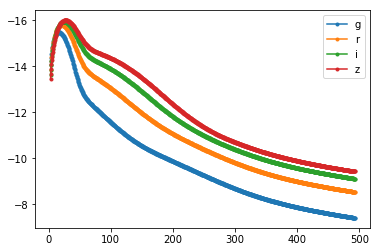

In [20]:
for band in ['g', 'r', 'i', 'z']:
    plt.plot(dataGW['time-rel'], dataGW[band], '.-', label=band)
plt.ylim(plt.ylim()[::-1])
plt.legend()

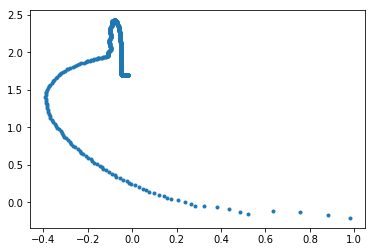

In [26]:

plt.plot(deltamagGW, colorGW, '.')

## metrics

#### three visits in 2 filters with specified filter pair and time gap

In [27]:
class threeVisitsWColorMetric(metrics.BaseMetric):
        
    def __init__(self, metricName="threevisits metric ", 
                 filterCol='filter', nightCol='night', 
                 mjdCol='observationStartMJD', dt1=0.5/24, dt2=1.5/24,
                 filters='gi', nVisitsMin=3, **kwargs):
        '''
        Calculates fields for which there are 3 visits in 2 filters with color within dt1 
        and shape at least separated by dt2
        
        returns 1 if the conditionas are all verified for the data slice, -666 otherwise
        default: dt1 30 min dt2 1.5 hours
        default filters y+g (cause there are a few)'''
        
        # Pass the same bins to the plotter.                                                      
        self.metricName = metricName
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol        
        self.nVisitsMin = nVisitsMin
        self.dt1 = dt1
        self.dt2 = dt2
        self.filters = (filters[0], filters[1])
        super(threeVisitsWColorMetric, 
              self).__init__(col=[self.mjdCol, 
                                self.nightCol, 
                                self.filterCol], 
                                metricDtype='int', 
                                units=filters, 
                                **kwargs)

    def run(self, dataSlice, slicePoint=None):
        mins = [99, 99]
        maxs = [-99, -99]
        sorting = np.argsort(dataSlice[self.mjdCol])
        dataSlice = dataSlice[sorting]
        #count the observations within a night for each slice
        n, counts = np.unique(dataSlice[self.nightCol], return_counts=True)
        #print(dataSlice)
        allslices = len(n)
        minobs = n[counts >= 3]
        #print(n, counts, minobs)
        dt1, dt2, filtshape = 100, -1, 'x'

        metricval = 0
        f = open(self.metricName+".csv", "a")
        #iterate over nights with more than 3 observations
        for i,night in enumerate(minobs):
            #this is a night with >=3 observations
            good = dataSlice[self.nightCol] == night
            
            #check if it has 2 filters at least
            n, count = np.unique(dataSlice[self.filterCol][good], 
                                 return_counts=True)
            if len(n) > 1:
                #print(dataSlice[self.filterCol][good])
                #print(n, count)
                #obs with filter 1
                #print (n, count)
                f0 = dataSlice[self.filterCol][good] == self.filters[0]
                #obs with filter 2
                f1 = dataSlice[self.filterCol][good] == self.filters[1]
                
                if f0.sum() == 0 or f1.sum() == 0:
                    metricval = 0.
                    return metricval
                
                if f0.sum() > 1:
                    #max gap with same filter
                    dt2 = dataSlice[self.mjdCol][good][f0][-1] - \
                               dataSlice[self.mjdCol][good][f0][0]
                    #print("dt2", dt2)
                    filtshape = self.filters[0]
                if f1.sum() > 1:
                    #max gap with same filter
                    _tmp = dataSlice[self.mjdCol][good][f1][-1] - \
                               dataSlice[self.mjdCol][good][f1][0]
                    #print("other dt2", _tmp)
                    if  _tmp > dt2:
                            filtshape = self.filters[1]
                            dt2 = _tmp
                dt1 = np.min([np.abs(t1-t2) for t1 in dataSlice[self.mjdCol][good][f0] 
                             for t2 in dataSlice[self.mjdCol][good][f1]])

                f.write("%s,%d,%s,%d,%.3f,%.3f\n"%(
                    self.filters[0], f0.sum(), 
                      self.filters[1], f1.sum(), 
                         dt1, dt2))
                #print (dt1 , "(", self.dt1, ")", dt2, "(", self.dt2, ")", filtshape)
               
            
                #see if obs verify  gap min and max conditions
                if dt1 <= self.dt1 and dt2 >= self.dt2:
                    metricval += 1.0
        f.close()
        #print(metricval)
        return metricval #/ allslices
    
    def reducep(self, metricval):
        result = np.sum(metricval)
        return result


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<400 and proposalId=3 for columns ['night', 'fieldDec', 'fieldRA', 'observationStartMJD', 'filter']
Found 213757 visits
Running:  ['metricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<400 and proposalId=3" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:302: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:302: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0
Plotting complete.


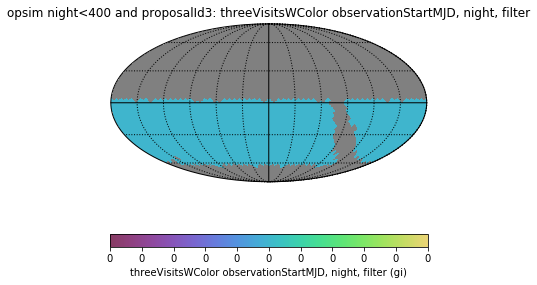

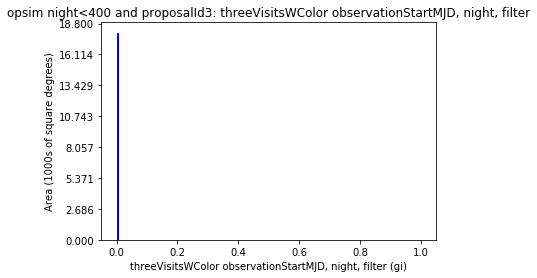

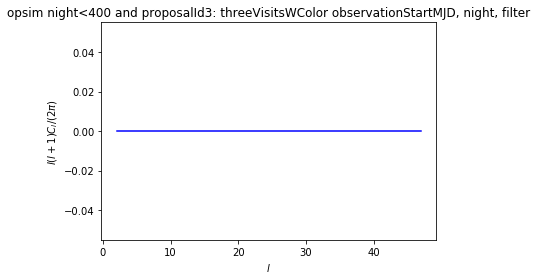

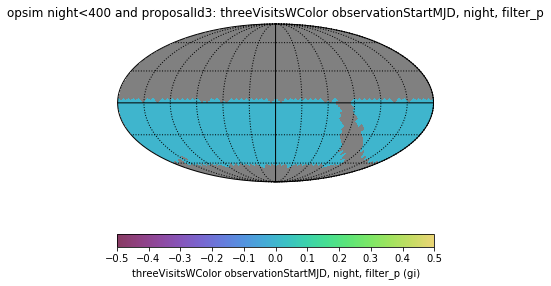

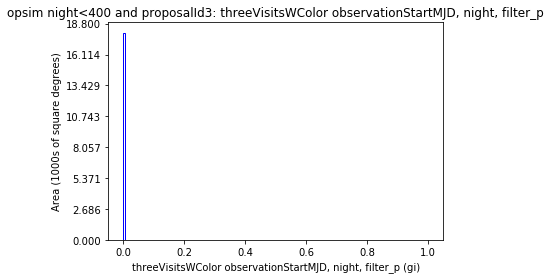

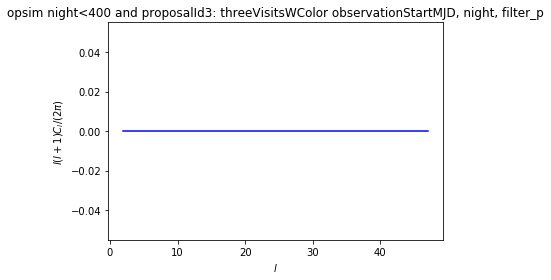

In [28]:
opsdb = opsdb_baseline
# run the metric 
metric = threeVisitsWColorMetric()
slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<400 and proposalId=3'

metricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

In [ ]:
opsdb = opsdb_pontus_2573
# run the metric 
metric = threeVisitsWColorMetric()
slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<400 and proposalId=3'

metricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

In [ ]:
import pylab as pl
def plotregions(filters, opsimdb, dt1=0.5, dt2=1.5):
    filterpairs = []
    ax = pl.figure().add_subplot(111)
    for i in list(itertools.combinations(['g','r','i','z'], 2)):
        #print (''.join(i), filters)
        if not ''.join(i) in filters:
            #print("skip")
            continue
        filterpairs.append(i)
        tmp = pd.read_csv(opsimdb + "/3visits" + ''.join(i) + ".csv", 
            header=None)
        tmp[4] = tmp[4] * 24
        tmp[5] = tmp[5] * 24
        tmp["c1"] = tmp[0].map({'g':1, 'r':2, 'i':3,'z':4})
        tmp["c2"] = tmp[2].map({'g':1, 'r':2, 'i':3,'z':4})
        ax = tmp.plot.scatter(x=4, y=5, alpha=0.2, color=colors[''.join(i)], 
                          ax=ax, label=''.join(i))
        ax.set_xlabel(r"$\Delta t_1$ (hours)", fontsize=15)
        ax.set_ylabel(r"$\Delta t_2$ (hours)", fontsize=15)
    
    ylim = (-2, 4.5)
    xlim = (0, 3.5)
    ax.set_ylim(ylim)
    
    ax.plot([dt1,dt1], [dt2,ylim[1]], 'k')

    ax.plot([xlim[0],  dt1], [dt2,dt2], 'k')
    ax.set_title(opsimdb + " healpix=64, year 1")
    pl.fill_between([xlim[0], 0.5, 0.5, xlim[1]],
                    [ylim[0], ylim[0], ylim[0], ylim[0]],
                    [1.5, 1.5, ylim[1], ylim[1]], color='k', alpha=0.1)

    print(filterpairs)
    pl.savefig("3visits" + "_" + opsimdb + "_" +
               ''.join([''.join(fp) for fp in filterpairs]) + ".png")
    return ((tmp[4] >= dt1) * (tmp[5] <= dt1)).sum() / len(tmp[4]), len(tmp[4])



#### FastTransientMetric

In [ ]:
from builtins import zip

class FastTransientMetric(BaseMetric):
    def __init__(self, metricName="FastTransientMetric", mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter',nightCol='night',
                 transDuration=10., riseSlope=0., 
                 surveyDuration=10., surveyStart=None, detectM5Plus=0.,
                 uPeak=20, gPeak=20, rPeak=20, iPeak=20, zPeak=20, yPeak=20,
                 dt1=0.5/24, dt2=1.5/24,  countMethod='full',
                 **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        super(FastTransientMetric, self).__init__(col=[self.nightCol, self.m5Col, self.filterCol,
                                                        self.mjdCol],
                                              units='Fraction Detected',
                                              metricName=metricName, **kwargs)
        self.peaks = {'u': uPeak, 'g': gPeak, 'r': rPeak, 'i': iPeak, 'z': zPeak, 'y': yPeak}
        self.transDuration = transDuration
        self.riseSlope = riseSlope
        self.surveyDuration = surveyDuration
        self.surveyStart = surveyStart
        self.detectM5Plus = detectM5Plus
        self.dt1 = dt1
        self.dt2 = dt2

    def lightCurve(self, time, filters):
        """
        Calculate the magnitude of the object at each time, in each filter.

        Parameters
        ----------
        time : numpy.ndarray
            The times of the observations.
        filters : numpy.ndarray
            The filters of the observations.

        Returns
        -------
        numpy.ndarray
            The magnitudes of the object at each time, in each filter.
        """
        lcMags = np.zeros(time.size, dtype=float)
        lcMags += self.riseSlope * time - self.riseSlope * self.transDuration
        for key in self.peaks:
            fMatch = np.where(filters == key)
            lcMags[fMatch] += self.peaks[key]
        return lcMags

    def run(self, dataSlice, slicePoint=None):
        """"
        Calculate the detectability of a transient with the specified lightcurve.

        Parameters
        ----------
        dataSlice : numpy.array
            Numpy structured array containing the data related to the visits provided by the slicer.
        slicePoint : dict, optional
            Dictionary containing information about the slicepoint currently active in the slicer.

        Returns
        -------
        float
            The total number of transients that could be detected.
        """
        # Total number of transients that could go off back-to-back
        nDetected = 0
        nTransMax = np.ceil(self.surveyDuration / (self.transDuration / 365.25))
        #print("number of events",  nTransMax, "detections", nDetected)
        
        if 1:
            # Compute the total number of back-to-back transients are possible to detect
            # given the survey duration and the transient duration.
            if self.surveyStart is None:
                surveyStart = dataSlice[self.mjdCol].min()
            time = (dataSlice[self.mjdCol] - surveyStart) % self.transDuration

            # Which lightcurve does each point belong to
            lcNumber = np.floor((dataSlice[self.mjdCol] - surveyStart) / self.transDuration)

            lcMags = self.lightCurve(time, dataSlice[self.filterCol])

            #always need to pass 3 criteria: 2 filters, max dt1 and min dt2

            # Flag points that are above the SNR limit
            detected = np.zeros(dataSlice.size, dtype=int)
            detected[np.where(lcMags < dataSlice[self.m5Col] + self.detectM5Plus * 2)] += 1

            #print([(lcMags[i], dataSlice[self.m5Col][i], self.detectM5Plus )
            #      for i in range(len(lcMags))])

            # Transients sould only have rise 
            #sort by time 
            sorting = np.argsort(dataSlice[self.mjdCol])
            dataSlice = dataSlice[sorting]
            detected = detected[sorting]
            lcNumber = lcNumber[sorting]
            time = time[sorting]
            ulcNumber = np.unique(lcNumber)
            left = np.searchsorted(lcNumber, ulcNumber)
            right = np.searchsorted(lcNumber, ulcNumber, side='right')
            # Note here I'm using np.searchsorted to basically do a 'group by'
            # might be clearer to use scipy.ndimage.measurements.find_objects or pandas, but
            # this numpy function is known for being efficient.
            #iterate over each event
            for le, ri in zip(left, right):
                thisSlice = dataSlice[le:ri]
                #print (thisSlice) 
    
                # Number of detections
                nd = np.sum(detected[le:ri])
                #print(nd)
                
                #need at least 3 detections
                if nd >= 3:
                    theseDetections = detected[le:ri].copy()
                    #iterate over each night
                    uniquedays = np.unique(thisSlice[self.nightCol][theseDetections > 0])
                    dayleft = np.searchsorted(thisSlice[self.nightCol][theseDetections > 0], 
                                              uniquedays)
                    dayright = np.searchsorted(thisSlice[self.nightCol][theseDetections > 0], 
                                               uniquedays, side='right')
                    #print(uniquedays) 
                    #print(dataSlice[le:ri][detected[le:ri] > 0])
                    n, counts = np.unique(thisSlice[self.nightCol][theseDetections > 0], 
                                          return_counts=True)
                    minobs = n[counts >= 3]
                    #if len(minobs)>0:
                    #    print("nights with >3 detections", minobs)
                    
                    
                    #iterate over nights with more than 3 observations
                    for i,night in enumerate(minobs):
                        #print("working on night", night)
                        #this is a night with >=3 observations
                        
                        thisNightSlice = thisSlice[(thisSlice[self.nightCol] == night) * 
                                                   (theseDetections > 0)]        
                        #print(thisNightSlice)
                        ufilters = np.unique(thisNightSlice[self.filterCol])
                   
                        #needs at least 2 filters
                        #print("filter", ufilters)
                        if len(ufilters) < 2:
                            detected[le:ri][dataSlice[self.nightCol][le:ri] == night] = 0
                            #print("only 1 filter")
                        else:
                            thisdt1 = []
                            thisdt2 = []
                            for f in ufilters:
                                thisfilter = thisNightSlice[self.filterCol] == f
                                thisFilterSlice = thisNightSlice[thisfilter]
                                #print(thisFilterSlice)
                                if len(thisFilterSlice) > 1:
                                    # data are sorted so max dt is last man min
                                    thisdt2.append(thisFilterSlice[self.mjdCol][0] - 
                                                   thisFilterSlice[self.mjdCol][-1])
                                #for every filter calculate min dt with all other filters
                                thisdt1.append(
                                    np.min([np.abs(t1 - t2)
                                        for t1 in thisFilterSlice[self.mjdCol] 
                                         for t2 in thisNightSlice[~thisfilter][self.mjdCol]]))
                            #print("maxs", thisdt2, "mins", thisdt1)
                            if np.max(np.array(thisdt2)) > self.dt2 and \
                                    np.min(np.array(thisdt1)) < self.dt1:
                                
                                detected[le:ri][dataSlice[self.nightCol]
                                                    [le:ri] == night] +=1
                                
                            #print ("detected", detected[le:ri])
               # Find the unique number of light curves that passed the required number of conditions
            
            nDetected += np.size(np.unique(lcNumber[np.where(detected > 1)]))
            #print("number of detections", nDetected)#, (detected > 1))
        # Rather than keeping a single "detected" variable, maybe make a mask for each criteria, then
        # reduce functions like: reduce_singleDetect, reduce_NDetect, reduce_PerLC, reduce_perFilter.
        # The way I'm running now it would speed things up.
        #print ("detection fraction", float(nDetected) / nTransMax)
        metricval = float(nDetected) / nTransMax
        return metricval
    def reducep(self, metricval):
        result = np.median(metricval)
        return result
